Num GPUs Available:  1


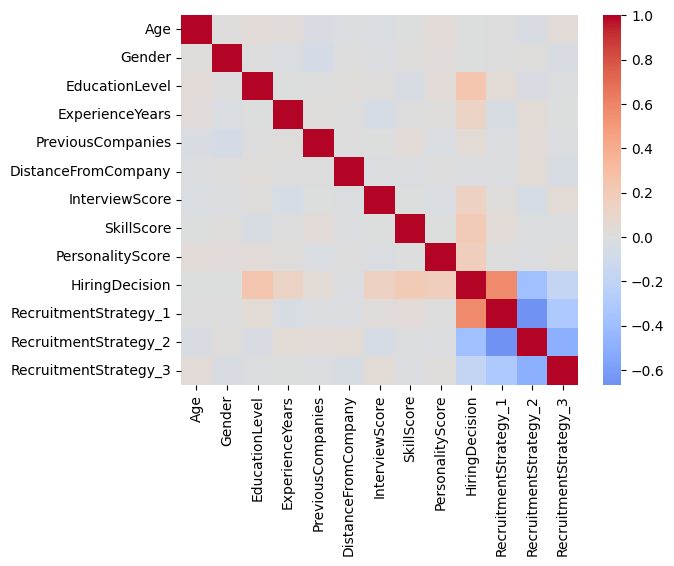

In [1]:
import numpy
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
import seaborn
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


recrutamento = pd.read_csv('recruitment_data.csv', sep=',', decimal='.')

# Instanciando o objeto One-Hot encoder, pois vai ser utilizada na coluna recrutamento Strategy
ohe = OneHotEncoder(handle_unknown='ignore')
# Fazendo a transformação
ohe_df = pd.DataFrame(ohe.fit_transform(recrutamento[['RecruitmentStrategy']]).toarray(), columns=['RecruitmentStrategy_1','RecruitmentStrategy_2','RecruitmentStrategy_3'])

# Agrupando a nova coluna com o df original
df = recrutamento.join(ohe_df)

recrutamento = df.drop(['RecruitmentStrategy'], axis=1)


corrPearson = recrutamento.corr('pearson')

seaborn.heatmap(corrPearson, annot=False, cmap='coolwarm', center=0)

features = list(recrutamento.columns.values)

classificacao = 'HiringDecision'

corrKendall = recrutamento.corr('kendall')

corrPearson = recrutamento.corr('pearson')

corrSpearman = recrutamento.corr('spearman')

tabela_correlacoes = pd.DataFrame()

tabela_correlacoes['kendal']= corrKendall['HiringDecision'].sort_values(ascending=False)
tabela_correlacoes['pearson']= corrPearson['HiringDecision'].sort_values(ascending=False)
tabela_correlacoes['spearman']= corrSpearman['HiringDecision'].sort_values(ascending=False)

tabela_correlacoes.drop(tabela_correlacoes[tabela_correlacoes['kendal']==1].index, inplace=True)

tabela_correlacoes

#Verifica-se que a estrategia de recrutamento  =1 que eh a agressiva, vai impactar muito na decisao final de contratacao

#removendo as features que tiveram indice de correlacao menor que 0.1
#tabela_correlacoes[tabela_correlacoes['kendal']<0.1].index

features.remove('PreviousCompanies')
features.remove('Age')
features.remove('Gender')
features.remove('DistanceFromCompany')

#Remove o output
features.remove(classificacao)

X = recrutamento[features].to_numpy() 
Y = recrutamento[classificacao].to_numpy() 



<AxesSubplot:xlabel='HiringDecision', ylabel='count'>

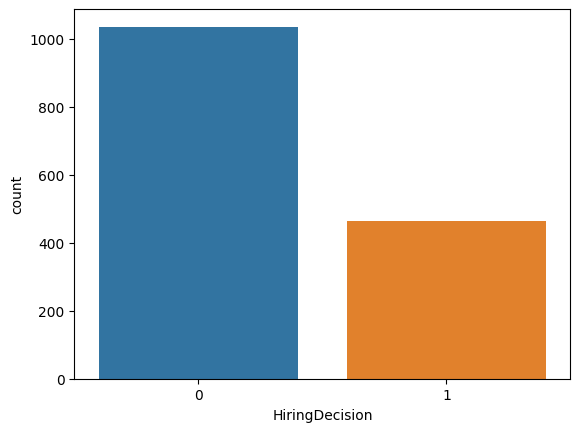

In [3]:
#Verificando que os dados estao desbalanceados
seaborn.countplot(x=classificacao,data=recrutamento)

In [5]:
#Eh interessante aplicar  o SMOTE para reduzir o vies em direcao a classe de " Nao contratados "
#A tecnica de SMOTE gera dados pra classe menos favorecida utilizando tecnica de KNN e ao mesmo tempo interpolacao
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)


<AxesSubplot:ylabel='count'>

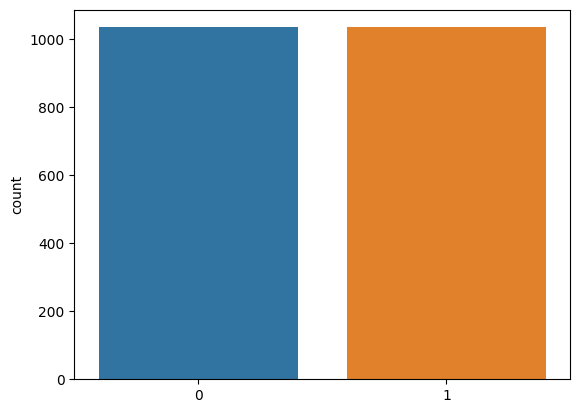

In [ ]:
#Agora os dados estao balanceados
seaborn.countplot(x=Y)


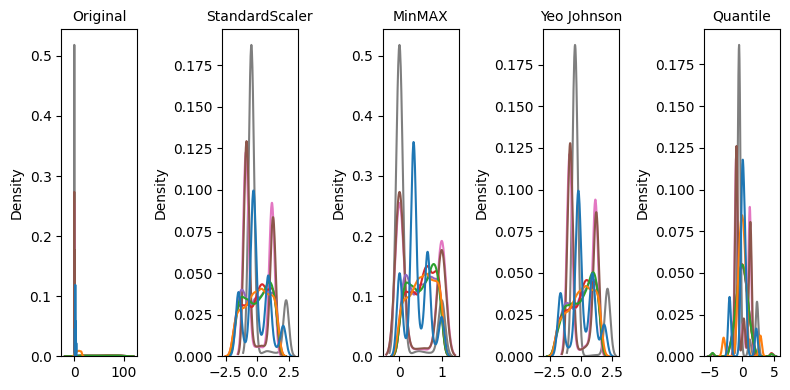

In [6]:
import matplotlib.pyplot as plt
STANDARD_SCALER = StandardScaler()
X_normalizado_standard = STANDARD_SCALER.fit_transform(X)


MIN_MAX_SCALER = MinMaxScaler(feature_range=(0, 1))
X_normalizado_min_max = MIN_MAX_SCALER.fit_transform(X)




from sklearn.preprocessing import PowerTransformer, QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')


pt = PowerTransformer(method='yeo-johnson')

teste_yeo_johnson = pt.fit_transform(X)
teste_yeo_johnson = STANDARD_SCALER.fit_transform(teste_yeo_johnson)

teste_quantile = qt.fit_transform(X)
teste_quantile = STANDARD_SCALER.fit_transform(teste_quantile)


f, axs = plt.subplots(1, 5, figsize=(8, 4))
seaborn.kdeplot(X, ax=axs[0], legend=False,)
axs[0].set_title('Original', size=10)

seaborn.kdeplot(X_normalizado_standard, ax=axs[1], legend=False,)
axs[1].set_title('StandardScaler', size=10)

seaborn.kdeplot(X_normalizado_min_max, ax=axs[2], legend=False,)
axs[2].set_title('MinMAX', size=10)


seaborn.kdeplot(teste_yeo_johnson, ax=axs[3], legend=False)
axs[3].set_title('Yeo Johnson', size=10)

seaborn.kdeplot(teste_quantile, ax=axs[4], legend=False)
axs[4].set_title('Quantile', size=10)

f.tight_layout()

X_transformado = teste_quantile




In [8]:
# PARAMETROS DA REDE 
from enum import Enum

class LossFunction(Enum):
    MSE = "mse"
    BINARY_CROSS = "binary_crossentropy"
    CATEGORICAL_CROSS="categorical_crossentropy"


class Optimizer(Enum):
    ADAM = "adam"
    RMSPROP="rmsprop"

class Activation(Enum):
    SIGMOID = "sigmoid"
    TANH="tanh"
    RELU="relu"
    

class Metrics(Enum):
    ACCURACY = "accuracy"
    PRECISION="precision"
    RECALL="recall"


In [9]:
#Testando com KerasClassifier
def create_model(neurons, activation, hidden_layers, loss_function, optimizer):
    # inputs = tf.keras.Input(shape=(X_transformado.shape[1],))
    # hidden = tf.keras.layers.Dense(neurons, activation=activation)(inputs)
    # hidden = tf.keras.layers.BatchNormalization()(hidden)
    # hidden = tf.keras.layers.Dense(neurons, activation=activation)(hidden)
    # hidden = tf.keras.layers.BatchNormalization()(hidden)

    model = tf.keras.models.Sequential()
    for layer in range(hidden_layers): 
        model.add(tf.keras.layers.Dense(neurons, input_shape=(X_transformado.shape[1],),  activation=activation))
        model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Dense(1, activation=Activation.SIGMOID.value))

    model.compile(loss=loss_function, optimizer=optimizer, metrics=[Metrics.ACCURACY.value])
    return model

funcoes_ativacao = [Activation.TANH.value ]#, Activation.RELU.value] 
metrica = Metrics.ACCURACY.value
# SEED que controla a aleatoriedade 
random_seed = 22
tf.random.set_seed(random_seed)
# create model
model = KerasClassifier(model=create_model, verbose=0)
# define the grid search parameters
neurons = [ X_transformado.shape[1]*2] #, X_transformado.shape[1]*3,X_transformado.shape[1]*4]
hidden_layers =[1] 
loss_function=[LossFunction.MSE.value]
optimezer_to_test= [Optimizer.ADAM.value]
param_grid = dict(epochs=[1500], model__neurons=neurons, model__activation=funcoes_ativacao,
                  model__hidden_layers= hidden_layers, model__loss_function= loss_function,
                  model__optimizer = optimezer_to_test  )
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_result = grid.fit(X_transformado, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))




Best: 0.926087 using {'epochs': 1500, 'model__activation': 'tanh', 'model__hidden_layers': 1, 'model__loss_function': 'mse', 'model__neurons': 16, 'model__optimizer': 'adam'}
0.926087 (0.025315) with: {'epochs': 1500, 'model__activation': 'tanh', 'model__hidden_layers': 1, 'model__loss_function': 'mse', 'model__neurons': 16, 'model__optimizer': 'adam'}


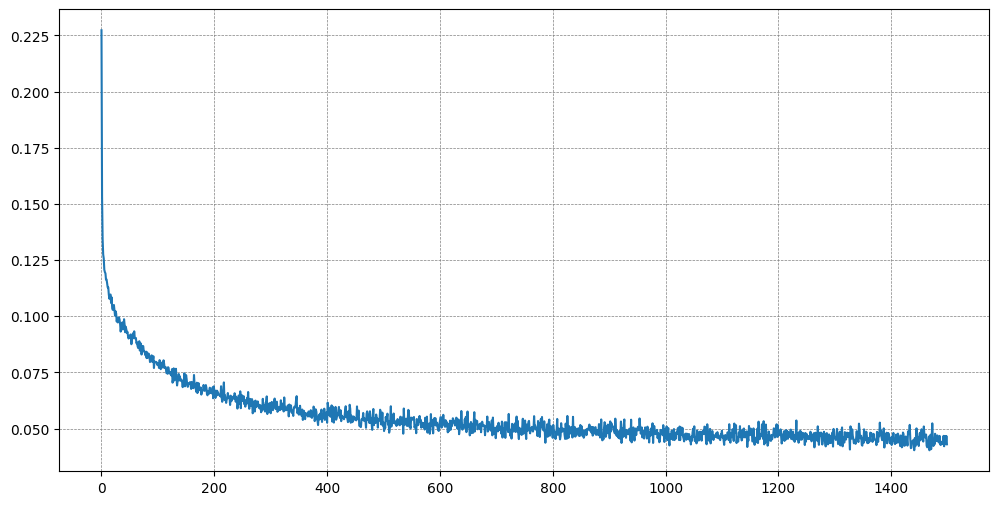

In [11]:
from matplotlib import pyplot

# PLOT TRAINING HISTORY
fig = pyplot.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
_ = ax.plot(grid_result.best_estimator_.history_['loss'], label='loss')
_ = ax.plot(grid_result.best_estimator_.history_['val_loss'], label='val_loss')
_ = ax.grid(which='major', linestyle='--', linewidth='0.5', color='gray')

In [22]:
len(X_transformado)

2070

In [26]:
TesteEntrada= [[3,14,31.70,54,50,1,0,0]]
np_teste  = numpy.array(TesteEntrada)

resultt = grid_result.best_estimator_.predict(np_teste)
resultt

array([1], dtype=int64)

In [27]:
win_model = grid_result.best_estimator_.model_

model_json = win_model.to_json()
with open("model/model.json", "w") as json_file:
    json_file.write(model_json)

#salvando os pesos aprendidos pela rede neural
win_model.save_weights("model/weights.h5")

In [ ]:
Y_est = grid_result.best_estimator_.predict(X_transformado, verbose=0)
relevance_dict = {}
df_X = recrutamento[features]
n_features_relevantes = 3

for feature in features:
    X_relevance = numpy.copy(X_transformado)
    X_relevance[:, df_X.columns == feature] = 0.0
    Y_est_relevance = grid_result.best_estimator_.predict(X_relevance, verbose=0)
    Y_relevance = (Y_est - Y_est_relevance)**2
    feature_relevance = Y_relevance.sum()/Y_relevance.shape[0]
    relevance_dict[feature] = feature_relevance
s_relevance = pd.Series(relevance_dict)
s_relevance_norm = s_relevance/s_relevance.max()
s_relevance_norm = s_relevance_norm.sort_values(ascending=False).head(n_features_relevantes)
selected_features = list(s_relevance_norm.index.values)
selected_relevance = list(100.0*s_relevance_norm.values)
df_relevance = pd.DataFrame({'feature': selected_features, 'relevance': selected_relevance})

In [ ]:
df_relevance

,feature,relevance
0,RecruitmentStrategy_1,100.000000
1,PersonalityScore,34.685315
2,EducationLevel,25.594406


In [ ]:
X_relevant = df_X[selected_features].to_numpy()

In [ ]:
Y_relevant = recrutamento[classificacao].to_numpy()

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_relevant, Y_relevant = oversample.fit_resample(X_relevant, Y_relevant)

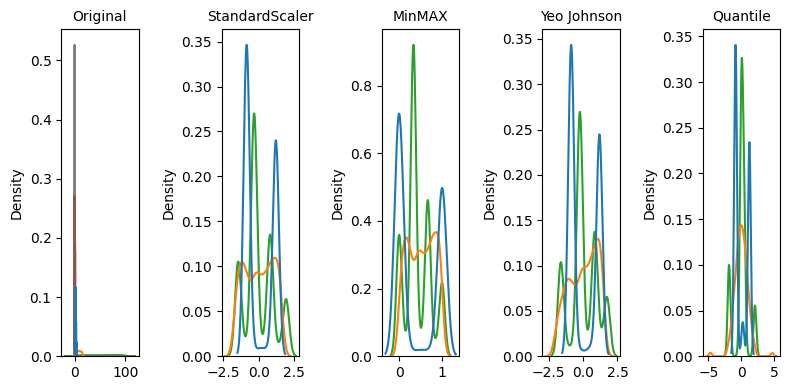

In [ ]:
import matplotlib.pyplot as plt
STANDARD_SCALER = StandardScaler()
X_normalizado_standard = STANDARD_SCALER.fit_transform(X_relevant)


MIN_MAX_SCALER = MinMaxScaler(feature_range=(0, 1))
X_normalizado_min_max = MIN_MAX_SCALER.fit_transform(X_relevant)




from sklearn.preprocessing import PowerTransformer, QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')


pt = PowerTransformer(method='yeo-johnson')


teste_yeo_johnson = pt.fit_transform(X_relevant)
teste_yeo_johnson = STANDARD_SCALER.fit_transform(teste_yeo_johnson)

teste_quantile = qt.fit_transform(X_relevant)
teste_quantile = STANDARD_SCALER.fit_transform(teste_quantile)


f, axs = plt.subplots(1, 5, figsize=(8, 4))
seaborn.kdeplot(X, ax=axs[0], legend=False,)
axs[0].set_title('Original', size=10)

seaborn.kdeplot(X_normalizado_standard, ax=axs[1], legend=False,)
axs[1].set_title('StandardScaler', size=10)

seaborn.kdeplot(X_normalizado_min_max, ax=axs[2], legend=False,)
axs[2].set_title('MinMAX', size=10)


seaborn.kdeplot(teste_yeo_johnson, ax=axs[3], legend=False)
axs[3].set_title('Yeo Johnson', size=10)

seaborn.kdeplot(teste_quantile, ax=axs[4], legend=False)
axs[4].set_title('Quantile', size=10)

f.tight_layout()

X_relevante_transformado = teste_quantile

In [ ]:
#Testando com KerasClassifier
def create_model(neurons, activation, hidden_layers, loss_function, optimizer):
    # inputs = tf.keras.Input(shape=(X_transformado.shape[1],))
    # hidden = tf.keras.layers.Dense(neurons, activation=activation)(inputs)
    # hidden = tf.keras.layers.BatchNormalization()(hidden)
    # hidden = tf.keras.layers.Dense(neurons, activation=activation)(hidden)
    # hidden = tf.keras.layers.BatchNormalization()(hidden)

    model = tf.keras.models.Sequential()
    for layer in range(hidden_layers): 
        model.add(tf.keras.layers.Dense(neurons, input_shape=(X_relevante_transformado.shape[1],),  activation=activation))
        model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Dense(1, activation=Activation.SIGMOID.value))

    model.compile(loss=loss_function, optimizer=optimizer, metrics=[Metrics.ACCURACY.value])
    return model

funcoes_ativacao = [Activation.TANH.value ]#, Activation.RELU.value] 
metrica = Metrics.ACCURACY.value
# SEED que controla a aleatoriedade 
random_seed = 22
tf.random.set_seed(random_seed)
# create model
model = KerasClassifier(model=create_model,batch_size=-1, verbose=0)
# define the grid search parameters
neurons = [16, 24] 
hidden_layers =[1, 2, 3] 
loss_function=[LossFunction.MSE.value]
optimezer_to_test= [Optimizer.ADAM.value]
param_grid = dict(epochs=[1500], model__neurons=neurons, model__activation=funcoes_ativacao,
                  model__hidden_layers= hidden_layers, model__loss_function= loss_function,
                  model__optimizer = optimezer_to_test  )
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_result = grid.fit(X_relevant, Y_relevant)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.839614 using {'epochs': 1500, 'model__activation': 'tanh', 'model__hidden_layers': 3, 'model__loss_function': 'mse', 'model__neurons': 16, 'model__optimizer': 'adam'}
0.831884 (0.018995) with: {'epochs': 1500, 'model__activation': 'tanh', 'model__hidden_layers': 1, 'model__loss_function': 'mse', 'model__neurons': 16, 'model__optimizer': 'adam'}
0.833816 (0.017842) with: {'epochs': 1500, 'model__activation': 'tanh', 'model__hidden_layers': 1, 'model__loss_function': 'mse', 'model__neurons': 24, 'model__optimizer': 'adam'}
0.777295 (0.096684) with: {'epochs': 1500, 'model__activation': 'tanh', 'model__hidden_layers': 2, 'model__loss_function': 'mse', 'model__neurons': 16, 'model__optimizer': 'adam'}
0.743478 (0.090667) with: {'epochs': 1500, 'model__activation': 'tanh', 'model__hidden_layers': 2, 'model__loss_function': 'mse', 'model__neurons': 24, 'model__optimizer': 'adam'}
0.839614 (0.021091) with: {'epochs': 1500, 'model__activation': 'tanh', 'model__hidden_layers': 3, 'model

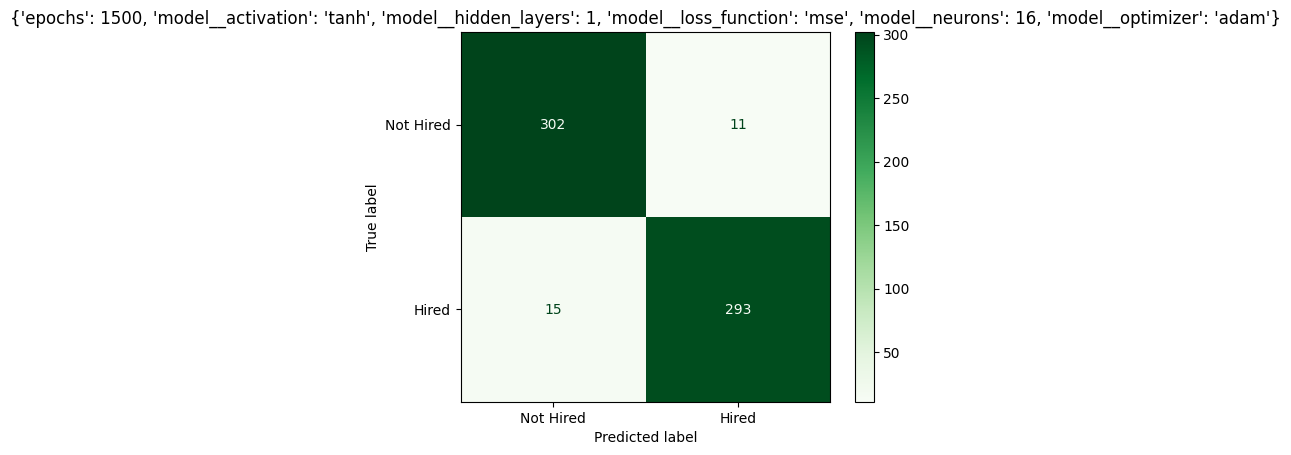

In [20]:
from sklearn.model_selection import train_test_split
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X_transformado,
                                                                  Y,
                                                                  test_size = 0.3,
                                                                  random_state = 0)

y_predict = grid_result.best_estimator_.predict(X_teste)

from sklearn.metrics import ConfusionMatrixDisplay
fig = ConfusionMatrixDisplay.from_predictions(y_teste, y_predict , display_labels=['Not Hired', 'Hired'], cmap='Greens')
plt.title(grid_result.best_params_)
plt.show()


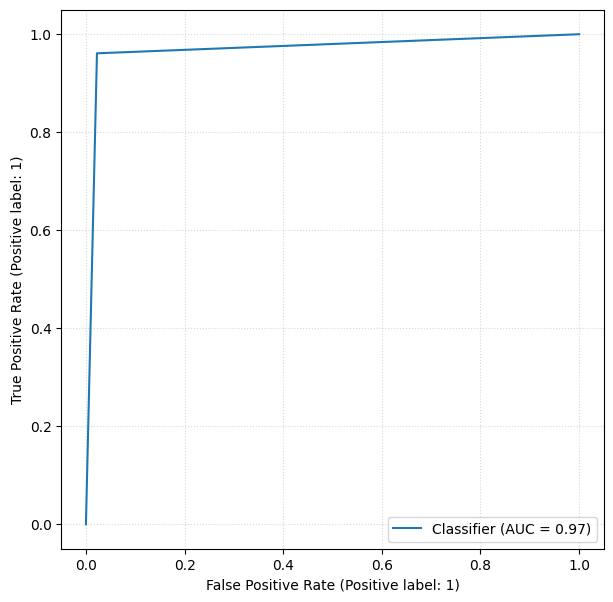

In [ ]:
from sklearn.metrics import RocCurveDisplay
from matplotlib import pyplot

fig = pyplot.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)
_ = RocCurveDisplay.from_predictions(y_teste, y_predict, ax=ax)
_ = ax.grid(alpha=0.5, ls=':')

Acurácia: 0.9420289855072463
Precisão: 0.9503311258278145
Recall: 0.9318181818181818
Especificidade: 0.952076677316294
F1 Score: 0.940983606557377
ROC AUC Score: 0.9728849425335048


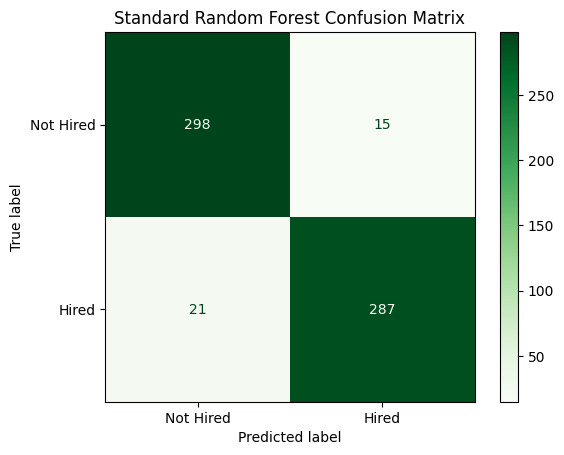

In [ ]:

#IMPLEMENTANDO O RANDOMFOREST SEM BALANCEAMENTO
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


# Divisão da base de dados entre treinamento e teste (30% para testar e 70% para treinar)
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X_transformado,
                                                                  Y,
                                                                  test_size = 0.3,
                                                                  random_state = 0)
# Criação do modelo e treinamento
# Funciona por meio de votação, ou seja, a classe que tiver mais votos é a classe que o modelo vai escolher
floresta = RandomForestClassifier(n_estimators = 100)
floresta.fit(X_treinamento, y_treinamento)

previsoes = floresta.predict(X_teste)

# Os valores percentuais da previsão
# predict_proba retorna a probabilidade de cada classe, o primeiro valor é a probabilidade de ser 0 e o segundo de ser 1
previsoes_percent = floresta.predict_proba(X_teste)
# As probabilidades de 1, usaremos para a função ROC
previsoes_percent = previsoes_percent[:,1]
previsoes_percent


matriz_confusao = confusion_matrix(y_teste, previsoes)
matriz_confusao

# Acurácia
accuracy = accuracy_score(y_teste, previsoes)
print("Acurácia:", accuracy)

# Precisão
precision = precision_score(y_teste, previsoes)
print("Precisão:", precision)

# Recall
recall = recall_score(y_teste, previsoes)
print("Recall:", recall)

# Especificidade.
tn, fp, fn, tp = confusion_matrix(y_teste, previsoes).ravel()
specificity = tn / (tn + fp)
print("Especificidade:", specificity)

# F1 Score
f1 = f1_score(y_teste, previsoes)
print("F1 Score:", f1)

# ROC AUC Score (necessita das probabilidades de classe em vez de previsões).
# Para calcular a ROC AUC é necessário passar a probabilidade de ser 1.
roc_auc = roc_auc_score(y_teste, previsoes_percent)
print("ROC AUC Score:", roc_auc)

fig = ConfusionMatrixDisplay.from_estimator(floresta, X_teste, y_teste, display_labels=['Not Hired', 'Hired'], cmap='Greens')
plt.title('Standard Random Forest Confusion Matrix')
plt.show()



In [ ]:
# TREINANDO





####### GRID SEARCH QUE FAZ O LOOP 
maximo_neuronios = 5
#quantidade de loops q vai esperar ate q o erro de teste comece a aumentar 
paciencia = 150
max_epocas =3*paciencia
min_improvement = 0.01
adam_initial_lr = 0.01
adam_lr_decay = 0.99
rollback_on_no_lower_bound_gain = True #se comecar o erro a subir, volta pra onde tava bom


n_k_folds = 5 #quantas partes o dataset vai ser dividido

tf.random.set_seed(random_seed)
#keras.utils.set_random_seed(random_seed)
# DIVIDE EM K PEDACOS
sk_folds = StratifiedKFold(n_splits=n_k_folds)
sk_folds.get_n_splits(X_transformado, Y)

metric_lower_bound = 0.0
metric_median = 0.0
resultados = []
for n_neuron in numpy.arange(1, maximo_neuronios+1):
    ix_fold = 1
    #divisao os grupos de treino e teste, ele faz pelos indices
    for train_index, test_index in sk_folds.split(X_transformado, Y):
        # pegar o dado do teste  e treino   a partir dos indices da divisao feita pelo skfolds
        X_train, X_test = X_transformado[train_index], X_transformado[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        for funcao_ativacao in funcoes_ativacao : 
            #configurando o otimizador 
            optimizer = tf.keras.optimizers.Adam( learning_rate=adam_initial_lr, 
                                                    beta_1=adam_lr_decay ) 
            
            # Configurando a rede
            model_name = f"ADAM-N{n_neuron}F{ix_fold}_{classificacao}_{funcao_ativacao}"
            val_metric_name = f'val_{metrica}'
            
            inputs = tf.keras.Input(shape=(X_transformado.shape[1], ))        
            hidden = tf.keras.layers.Dense(n_neuron, activation=funcao_ativacao)(inputs)
            outputs = tf.keras.layers.Dense(1, activation='sigmoid')(hidden) #penas 1 classificacao = 1 saida
            rede = tf.keras.Model(inputs=inputs, outputs=outputs, name=model_name)

            #Usar o otimizador com erro medio quadratico 
            rede.compile(optimizer=optimizer, loss='mse', metrics=[metrica])
            
            #early stop com foco no erro do grupo de validacao
            es_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=paciencia, restore_best_weights=True)
            #early stop com foco na acuracia dos testes
            es_metric = tf.keras.callbacks.EarlyStopping(monitor=metrica, mode='max', patience=paciencia, min_delta=min_improvement, restore_best_weights=True)


            #iniciando a rede para tentar encontrar o modelo
            resultado = rede.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=X_train.shape[0], 
                                    epochs=max_epocas, verbose=0, callbacks=[es_loss, es_metric], )

        

            # RESULTADOS DA REDE
            model_loss = resultado.history['loss'][-1]
            model_val_loss = resultado.history['val_loss'][-1]
            metric_val = resultado.history[metrica][-1]
            val_metric_val = resultado.history[val_metric_name][-1]
            n_epochs = len(resultado.history['val_loss'])

            resultado_dict = {'model_name': model_name,
                            'optimizer': optimizer,
                            'neurons': n_neuron,
                            'fold': ix_fold,
                            'loss': model_loss,
                            'val_loss': model_val_loss,
                            metrica: metric_val,
                            val_metric_name: val_metric_val,
                            'epochs': n_epochs,
                            'net': rede,
                            'history': resultado}
            resultados.append(resultado_dict)

            print(f"{model_name} > epochs: {n_epochs} loss: {model_loss} val_loss: {model_val_loss} {metrica}: {100.0*metric_val}% {val_metric_name}: {100.0*val_metric_val}%")
                

            # SE CHEGAR NO 100% para de aumentar 
            maximized_metrics = (val_metric_val == 1.0) & (metric_val == 1.0)

            if maximized_metrics:
                break

            print('')
        ix_fold += 1
        
    # GET LOWER BOUND OF WINNING ALGORITHM
    df_resultados = pd.DataFrame(resultados)


ADAM-N1F1_HiringDecision_tanh > epochs: 317 loss: 0.12350894510746002 val_loss: 0.12206868082284927 Accuracy: 84.29951667785645% val_Accuracy: 84.29951667785645%

ADAM-N1F1_HiringDecision_relu > epochs: 445 loss: 0.12401490658521652 val_loss: 0.1286454200744629 Accuracy: 84.3599021434784% val_Accuracy: 83.09178948402405%

ADAM-N1F2_HiringDecision_tanh > epochs: 206 loss: 0.12897154688835144 val_loss: 0.10528505593538284 Accuracy: 83.27294588088989% val_Accuracy: 87.19806671142578%

ADAM-N1F2_HiringDecision_relu > epochs: 413 loss: 0.12646572291851044 val_loss: 0.11069495975971222 Accuracy: 84.17874574661255% val_Accuracy: 85.26570200920105%

ADAM-N1F3_HiringDecision_tanh > epochs: 237 loss: 0.11758480966091156 val_loss: 0.1606757789850235 Accuracy: 84.54106450080872% val_Accuracy: 80.67632913589478%

ADAM-N1F3_HiringDecision_relu > epochs: 247 loss: 0.11706136912107468 val_loss: 0.162090003490448 Accuracy: 84.78260636329651% val_Accuracy: 80.91787695884705%

ADAM-N1F4_HiringDecision_ta

In [ ]:
resultado_resumido = pd.DataFrame()

lista_dict = []
for qtde_neuronio in numpy.arange(1, maximo_neuronios+1):
    for funcao_ativacao in funcoes_ativacao:
        filtrado = df_resultados[(df_resultados['neurons']==qtde_neuronio) & (df_resultados['model_name'].str.contains(funcao_ativacao))]
        temp_dict ={}
        temp_dict['neuronios'] = qtde_neuronio
        temp_dict['ativacao'] = funcao_ativacao
        temp_dict[f'{metrica}_media'] =  filtrado.loc[:, metrica].mean()
        stringVal = f'val_{metrica}'
        temp_dict[f'{stringVal}_media'] =  filtrado.loc[:, stringVal].mean()
        temp_dict[f'epocas_media'] =  filtrado.loc[:, 'epochs'].mean()
        temp_dict[f'val_loss_media'] =  filtrado.loc[:, 'val_loss'].mean()
        temp_dict[f'loss_media'] =  filtrado.loc[:, 'loss'].mean()
        lista_dict.append(temp_dict)
        

resultado_resumido = pd.DataFrame(lista_dict)
resultado_resumido.sort_values(by=f'{metrica}_media', ascending=False)

,neuronios,ativacao,Accuracy_media,val_Accuracy_media,epocas_media,val_loss_media,loss_media
8,5,tanh,0.863889,0.849275,322.2,0.113365,0.104177
6,4,tanh,0.862319,0.848792,251.0,0.110452,0.104052
9,5,relu,0.860145,0.851208,259.2,0.117588,0.110766
7,4,relu,0.850845,0.831884,230.0,0.126477,0.114742
4,3,tanh,0.848068,0.835266,298.6,0.122966,0.115300
5,3,relu,0.846498,0.838647,290.0,0.124284,0.116579
2,2,tanh,0.842995,0.831401,280.8,0.126554,0.118652
1,1,relu,0.842754,0.831884,398.8,0.133513,0.125094
0,1,tanh,0.840459,0.837681,277.4,0.129594,0.124508
3,2,relu,0.839976,0.838164,257.4,0.133245,0.125627
